In [601]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
import operator


In [602]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import os
import sys

if os.getcwd() == '/workspace/newSlab':
    sys.path.append('../unsupported')

#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../unsupported')
except:
    pass

from unsupported_dan.interfaces.marker2D import markerLine2D, line_collection

In [603]:
minX = -1.0
maxX = 1.0
resX = 48
resY = 24
elementType="Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, -0.5), 
                                 maxCoord    = ( maxX, 0.5),
                                 periodic    = [False, False]  ) 


velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )

velocityField.data[:] = [0.,0.]


In [604]:
coordinate = fn.input()
yFn = coordinate[1]

In [605]:
velocityField.data[:,0] = 2.*yFn.evaluate(mesh)[:,0] #dVx/dy = 1
velocityField.data[:,1] = 0.

In [606]:
swarm = uw.swarm.Swarm( mesh=mesh, particleEscape=False)
proximityVariable = swarm.add_variable( dataType="int", count=1 )
directorVariable   = swarm.add_variable( dataType="double", count=2)

swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

proximityVariable.data[:] = 0
directorVariable .data[:] = (0.0, 0.0)

In [607]:
bWalls =mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]

markerXs = np.linspace(-0.8, 0.8, 40)
markerYs = np.linspace(-0.4, 0.4, 40)


markerThickness = 0.1

line1 = markerLine2D(mesh, velocityField, markerXs, markerYs, 
                        markerThickness, 1, insidePt=(0.,-10.))

line2 = markerLine2D(mesh, velocityField, markerXs, -1.*markerYs, 
                        markerThickness, 2, insidePt=(0.,-10.))


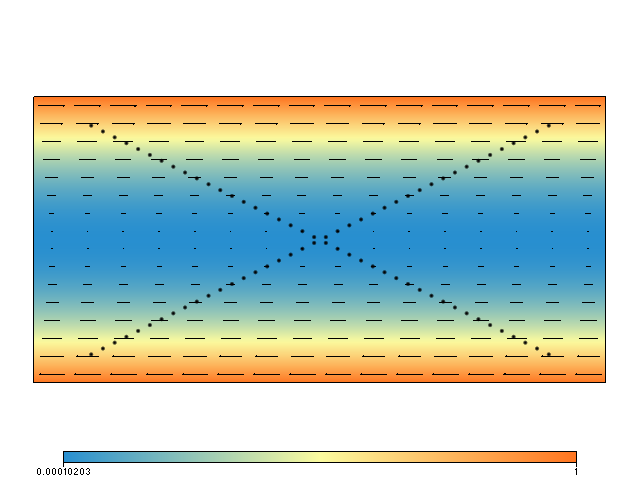

In [608]:
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=.1) )
fig1.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField, velocityField)) )
fig1.append( glucifer.objects.Points(line1.swarm, pointsize = 5))
fig1.append( glucifer.objects.Points(line2.swarm, pointsize = 5))

fig1.show()

In [609]:
proximity, fpts = line1.compute_marker_proximity(swarm.particleCoordinates.data)

proximityVariable.data[fpts] = proximity[fpts]


proximity, fpts = line2.compute_marker_proximity(swarm.particleCoordinates.data)

proximityVariable.data[fpts] = proximity[fpts]


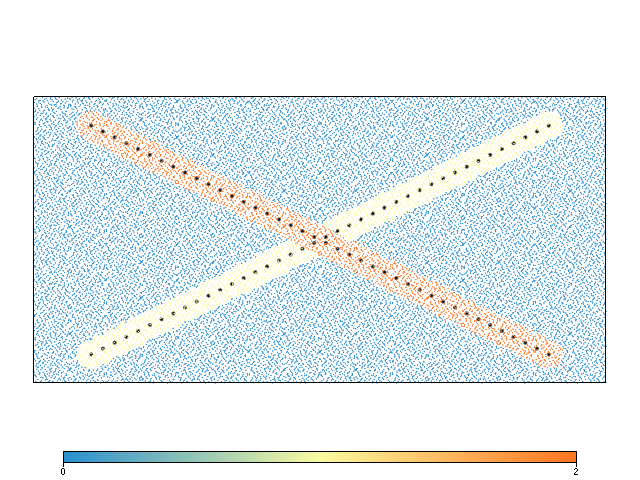

In [610]:
fig2 = glucifer.Figure()
fig2.append( glucifer.objects.Points(swarm, proximityVariable, pointsize = 2))
fig2.append( glucifer.objects.Points(line1.swarm, pointsize = 5))
fig2.append( glucifer.objects.Points(line2.swarm, pointsize = 5))


fig2.show()

In [611]:
#is this safe in parallel??

def set_proximity_director(self, swarm, proximity, minDistanceFn, maxDistanceFn, locFac=0.5, normal=False ):
    
    #################
    #Part1
    ################
    
    minDistanceFn*= self.thickness
    thickness= minDistanceFn.evaluate(swarm)
    
    faultLoc = locFac*thickness
    
    
    #First, we want to rebuild the minimum distance...
    sd, pts0 = self.compute_signed_distance(swarm.particleCoordinates.data, 
                                                distance=1.*self.thickness)
    
    #everthing in the min dist halo becomes fault.
    mask = np.logical_and(sd<(thickness - faultLoc),sd>-1.*faultLoc)[:,0]   
    proximity.data[mask ] = self.ID
    
    
    #################
    #Part2
    ################
    
    #Now we can cull particles beyond the max distance...
    sd, pts0 = self.compute_signed_distance(swarm.particleCoordinates.data, 
                                            distance=1.*self.thickness*50) #choose a big halo for this
    
    
    
    #here, were finding paricles with proximity == self.ID, which are beyond the retention distance, 
    #and we're stting them back to zero
    #I had to do these separately for the two sides of the fault
       
    maxDistanceFn*= self.thickness
    thickness= maxDistanceFn.evaluate(swarm)
    faultLoc = locFac*thickness
    
    
    mask1 = operator.and_(sd > (thickness - faultLoc),proximity.data == self.ID)
    proximity.data[mask1] = 0
    mask2 = operator.and_(sd < -1*faultLoc,proximity.data == self.ID)
    proximity.data[mask2] = 0
    
    
    #################
    #Part3
    ################
    
    
    if normal:
        #director domain will be larger than proximity, but proximity will control rheology
        #5*self.thickness should capture the max procimity distance from the fault
        dv, nzv = self.compute_normals(swarm.particleCoordinates.data, 5.*self.thickness)
        mask = np.where(proximity.data == self.ID)[0]
        normal.data[mask, :] = dv[mask, :]
        
    
    
    #return sd, dv, mask

In [615]:
minDistFn = fn.misc.constant(1.)
minDistFn = 3.*fn.math.abs(fn.math.cos(4.*coordinate[0]))


maxDistFn = 4.*fn.math.abs(coordinate[0])
#minDistFn*=2.

In [616]:
#proximityVariable.data[1:20] = 1.
#proximityVariable.data[1:20]
#line1.ID

In [617]:
proximityVariable.data[:] = 0


In [618]:
mask= swarm.particleCoordinates.data[:,0] < 0.0
proximityVariable.data[mask] = 0

#mask2= swarm.particleCoordinates.data[:,0] < -0.25
#proximityVariable.data[mask] = line1.ID

In [631]:
#import types

#meth = types.MethodType(f, C(), C)

markerLine2D.proximity_director = proximity_director

In [634]:
dummy = line1.proximity_director(swarm, proximityVariable, 
                                        minDistFn, maxDistFn, directorVariable)

In [635]:
dummy = markerLine2D.proximity_director(line2,swarm, proximityVariable, 
                                        minDistFn, maxDistFn, directorVariable )

In [636]:
markerLine2D.proximity_director(line2,swarm, proximityVariable, 
                                        minDistFn, maxDistFn, directorVariable )

In [637]:
#directorVariable.data[mask ] = dv[mask]

In [638]:
#dv[mask]


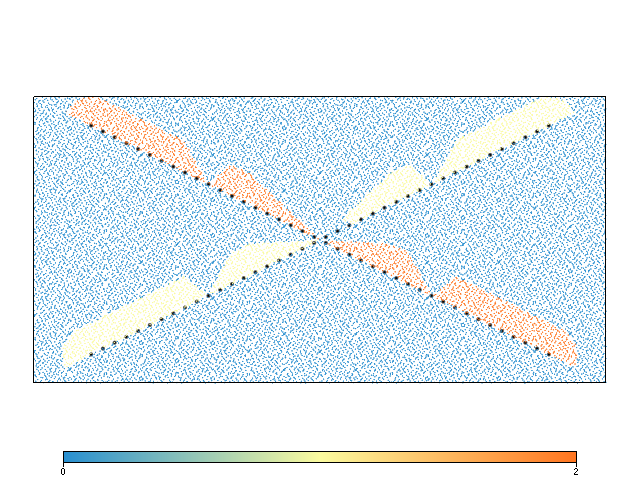

In [639]:
fig3 = glucifer.Figure()
fig3.append( glucifer.objects.Points(swarm, proximityVariable, pointsize = 2))
fig3.append( glucifer.objects.Points(line1.swarm, pointsize = 5))
fig3.append( glucifer.objects.Points(line2.swarm, pointsize = 5))
fig3.show()

## Strain rate components

In [362]:
#If there is just one marker line, we can use:
#edotn_SFn, edots_SFn = line1.local_strainrate_fns( velocityField, directorVariable, proximityVariable)

#However, if there are two markerlines it's better to put them in a collection and do this

line_coll = line_collection([line1, line2])

edotn_SFn, edots_SFn = line_coll.global_line_strainrate_fns( velocityField, directorVariable, proximityVariable)


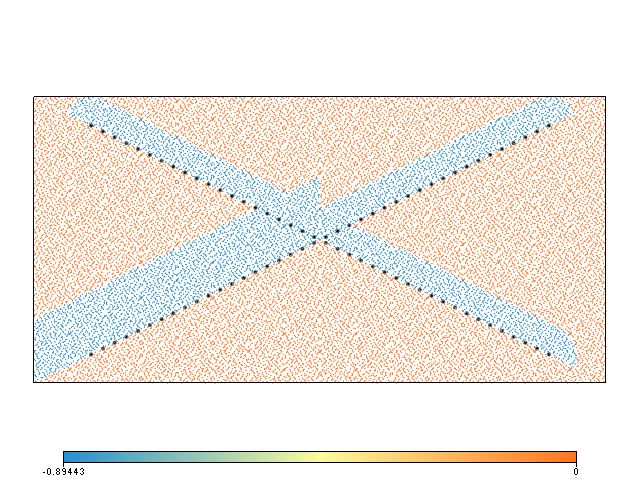

In [365]:
#

fig4 = glucifer.Figure()
#fig4.append( glucifer.objects.Points(swarm, fn.math.sqrt(edots_SFn**2 + edotn_SFn**2), pointsize = 2))
fig4.append( glucifer.objects.Points(swarm, directorVariable[1], pointsize = 2))

fig4.append( glucifer.objects.Points(line1.swarm, pointsize = 5))
fig4.append( glucifer.objects.Points(line2.swarm, pointsize = 5))
fig4.show()